In [1]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# import numpy as sns
# import pandas as np
# import seaborn as pd
# import matplotlib.pyplot as torch

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Загружаем все данные

In [2]:
df = pd.read_csv('data.csv', index_col=0).drop(columns=['Unnamed: 0'])
df_bac = pd.read_csv('bacterial_descriptors.csv', index_col=0)
df_drug = pd.read_csv('drug_descriptors.csv', index_col=0)

# Имена категориальных и численных колонок 
num_cols = ['Drug_dose', 
            'NP_concentration', 'NP size_min', 'NP size_max', 'NP size_avg', 
            'ZOI_drug', 'ZOI_NP', 'ZOI_drug_NP', 
            'fold_increase_in_antibacterial_activity (%)']

cat_cols = ['Bacteria', 'NP_Synthesis', 'Drug',	'Drug_class_drug_bank', 'shape', 'method', 'MDR_check']

df

,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
0,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,4.0,10.0,8.00,spherical,MIC,32+,6.3,32+,NaN,1
1,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,4.0,10.0,8.00,spherical,MIC,32+,6.3,32+,NaN,1
2,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,15.0,30.0,28.00,spherical,MIC,32+,25,32+,NaN,1
3,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,15.0,30.0,28.00,spherical,MIC,32+,25,32+,NaN,1
4,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Vancomycin,Carboxylic acids and derivatives,30.0,100,5.0,30.0,21.00,spherical,disc_diffusion,0,14,17+2,7.02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,Staphylococcus aureus,green_synthesis using C. zylinicum aqueous ext...,NaN,NaN,NaN,NaN,10.0,78.9,44.45,spherical,MIC,NaN,4.5,NaN,NaN,0
879,Acinetobacter baumanii,green_synthesis using C. zylinicum aqueous ext...,NaN,NaN,NaN,NaN,10.0,78.9,44.45,spherical,MIC,NaN,5.7,NaN,NaN,0
880,Enterococcus faecalis,green_synthesis using extract of Klebsiella pn...,NaN,NaN,NaN,10,20.0,20.0,20.00,spherical,disc_diffusion,NaN,10,NaN,NaN,0
881,Enterococcus faecalis,green_synthesis using extract of Klebsiella pn...,NaN,NaN,NaN,20,20.0,20.0,20.00,spherical,disc_diffusion,NaN,18,NaN,NaN,0


# Предварительная обработка drug_descriptors 

In [3]:
# Выкидываем, не понадобится: есть смайлс
df_drug.drop(columns=['prefered_name', 'chemID'], inplace=True)

# Все с маленькой буквы, strip на строки для очистки
df_drug = df_drug.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_drug['drug'] = df_drug['drug'].map(lambda x: x.lower() if isinstance(x, str) else x)
df['Drug'] = df['Drug'].map(lambda x: x.lower() if isinstance(x, str) else x)
df_drug = df_drug.rename(columns={'drug': 'Drug', 'smiles': 'Smiles'})

# Откуда-то взялись дубликаты, выкидываем не думая
df_drug.drop_duplicates(inplace=True)
df_drug = df_drug.reset_index(drop=True)

Проверяем, что в БД drug есть все вещества, какие есть в data

In [4]:
drugs_in_drugs = set(df_drug.Drug.unique())
drugs_in_data = set(df.Drug.unique())
drugs_in_data.difference(drugs_in_drugs)

{nan, 'neomycin'}

Не хватает неомицина, добавим его вручную (SMILES с учетом хиральности из PubChem)

In [5]:
Neomycin = {
    'Drug': ['neomycin'],
    'Smiles': [
        'C1[C@H]([C@@H]([C@H]([C@@H]([C@H]1N)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CN)O)O)N)O[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O[C@@H]4[C@@H]([C@H]([C@@H]([C@@H](O4)CN)O)O)N)O)O)N'
    ]
}
row_to_append = pd.DataFrame(Neomycin)
df_drug = pd.concat([row_to_append, df_drug]).reset_index(drop=True)

## Подгрузка дополнительных признаков
 1. pKa: вычисляли с помощью J. Chem. Inf. Mod. 61(1) http://dx.doi.org/10.1021/acs.jcim.1c00075 - нейросеть, ее валидация R^2 0.75-0.95 в зависимости от основности/кислотности молекулы 

In [6]:
pKa = pd.read_csv('pKa.csv', sep=';')
pKa['Name'] = pKa['Name'].map(lambda x: x.lower() if isinstance(x, str) else x)

df_drug = pd.merge(df_drug, pKa, left_on='Drug', right_on='Name').drop(columns=['Name'])



2. Пишем функцию, чтобы легко добавлять дескрипторы из RDKit

In [7]:
def add_desc_to_df(df: pd.DataFrame, desc: list):
    '''
    Add column with descriptors values to df
    
    Parameters
    ----------
    df: pd.DataFrame

    desc: list[str]
    '''

    calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc)
    desc_df = pd.DataFrame(
        df['Smiles'].map(lambda x: calc.CalcDescriptors(Chem.MolFromSmiles(x))).to_list()
    )
    desc_df.columns = desc
    return df.join(desc_df)

Добавляем дескрипторы, см. ```descs_to_add```

In [8]:
descs_to_add = [
    'LabuteASA', 'NumHDonors', 'NumHAcceptors', 
    'MolLogP', 'MolWt', 'Chi0', 'RingCount', 'TPSA'
]

df_drug = add_desc_to_df(df_drug, descs_to_add)

# Предварительная обработка bacterial_descriptors

## Думаем над фичами

1. Три коррелирующих числа (min max и avg время инкубации) нам ни к чему, но можно посчитать "размах" - вдруг он окажется полезным

In [9]:
df_bac['min_max_Incub_period'] = df_bac['max_Incub_period, h'] - df_bac['min_Incub_period, h']
df_bac.drop(columns=['max_Incub_period, h', 'min_Incub_period, h'], inplace=True)

In [11]:
df_bac

,Bacteria,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"avg_Incub_period, h","growth_temp, C",biosafety_level,isolated_from,min_max_Incub_period
Tax_id,,,,,,,,,,,,,,,,
['470'],Acinetobacter baumannii,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,Acinetobacter calcoaceticus/baumannii complex,n,36.00,37,2,urine,24.00
['715'],Actinobacillus pleuropneumoniae,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Actinobacillus,Actinobacillus pleuropneumoniae,n,36.00,37,2,lungs,24.00
['5599'],Alternaria alternata,Fungi,Dikarya,Opisthokonta,Ascomycota,Dothideomycetes,Pleosporales,Pleosporaceae,Alternaria,Alternaria alternata,NaN,192.00,30,2,food,288.00
['5059'],Aspergillus flavus,Fungi,Dikarya,Opisthokonta,Ascomycota,Eurotiomycetes,Eurotiales,Aspergillaceae,Aspergillus,Aspergillus flavus,NaN,36.00,37,2,soil,24.00
['162425'],Aspergillus nidulans,Fungi,Dikarya,Opisthokonta,Ascomycota,Eurotiomycetes,Eurotiales,Aspergillaceae,Aspergillus,Aspergillus nidulans,NaN,36.00,30,1,soil,24.00
['5061'],Aspergillus niger,Fungi,Dikarya,Opisthokonta,Ascomycota,Eurotiomycetes,Eurotiales,Aspergillaceae,Aspergillus,Aspergillus niger,NaN,36.00,30,1,soil,24.00
['1396'],Bacillus cereus,Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus cereus group,p,10.00,30,2,food,12.00
['1402'],Bacillus licheniformis,Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus subtilis group,p,20.00,37,1,soil,8.00
['1386'],Bacillus sp.,Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,unclassified Bacillus,p,10.00,30,2,soil,12.00


Обнаружилась корреляция ```min_max_Incub_period``` с ```avg_Incub_period```, но график выглядит не так уж страшно линейным, поэтому попробуем.

ValueError: Could not interpret value `avg_Incub_period` for parameter `x`

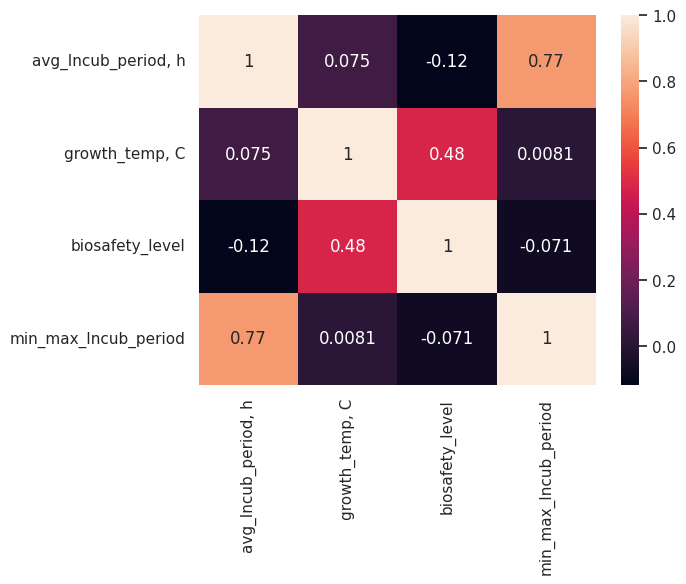

In [10]:
sns.heatmap(df_bac.corr(numeric_only=True), annot=True)
sns.scatterplot(df_bac, x='avg_Incub_period', y='min_max_Incub_period')